# **BASELINE - UNET**

# Architecture
<img src="UNET Architecture.png" alt="architecture" style="background:#fff"/>

# Import Dependencies

In [161]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap
import bitsandbytes as bnb

In [162]:
torch.__version__

'2.2.2+cu121'

In [163]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [164]:
torch.cuda.is_available()

True

# Config

In [165]:
len(os.listdir("Numpy Dataset\\all\images"))

7547

In [166]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_new = True
    model_num = len(os.listdir("Models")) if train_new else len(os.listdir("Models"))-1

    batch_size = 8
    nEpochs = 20
    lr = 0.1

    TH = 0.8

    model_name = f"baseline_{model_num}"

In [167]:
import warnings
warnings.filterwarnings("ignore")

In [168]:
torch.cuda.empty_cache()
gc.collect()

31415

In [169]:
torch.cuda.memory_usage()

56

In [170]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [171]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Load Data

In [172]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [173]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [174]:
class CTDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.dir = dir
        self.images_path = join(dir, "images")
        self.labels_path = join(dir, "labels")
        self.images = os.listdir(self.images_path)
        self.labels = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        try:
            img = np.load(join(self.images_path, self.images[idx]), allow_pickle=True)
            img = img.reshape(1, 512, 512) # Hard coded since all images are 512, 512

            label = np.load(join(self.labels_path, self.labels[idx]), allow_pickle=True)
            label = label.reshape(1, 512, 512)
        except:
            img, label = np.zeros((1,512,512), np.float32),np.zeros((1,512,512), np.float32)
        return  img,label

In [175]:
train = CTDataset("Numpy Dataset\\train")
valid = CTDataset("Numpy Dataset\\valid")
test = CTDataset("Numpy Dataset\\test")

In [176]:
trainDL = DataLoader(train, batch_size=CFG.batch_size,shuffle=True, pin_memory=True)
validDL = DataLoader(valid, batch_size=CFG.batch_size)
testDL = DataLoader(test, batch_size=1)

In [177]:
print(f"Train: {len(train)}")
print(f"Valid: {len(valid)}")
print(f"Test: {len(test)}")

Train: 5331
Valid: 1598
Test: 616


# Model

In [178]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [179]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [180]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [181]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out = Conv2d(channels[1], 1, 1)

        # init random weights
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        # x = F.interpolate(x, (512,512))
        x = F.sigmoid(x)

        return x

In [182]:
if not CFG.train_new:
    try:
        model = torch.load(f"Models/{CFG.model_name}/{CFG.model_name}.pt")
    except FileNotFoundError:
        print("Model not found in models folder")

# Train

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [183]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [184]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):   
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [185]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [186]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, ALPHA = 0.5, BETA = 0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = ALPHA
        self.beta = BETA

    def forward(self, inputs, targets, smooth=1):  
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [187]:
criterion_dice = DiceBCELoss()

In [188]:
criterion_iou = IoULoss()

In [189]:
criterion_bce = torch.nn.BCEWithLogitsLoss()

In [190]:
criterion_tversk = TverskyLoss()

## Training Loop

In [191]:
model = UNET().to(CFG.device)
optim = AdamW(model.parameters(), lr=CFG.lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)

trainDL = DataLoader(train, batch_size=16, shuffle=True)
validDL = DataLoader(valid, batch_size=16, shuffle=False)

In [192]:
torch.cuda.empty_cache()
gc.collect()

85

In [193]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
f"{get_n_params(model)} Trainable Parameters"

'7759521 Trainable Parameters'

In [194]:
def train_epoch(model,  criterion, optim, scheduler):      
    train_loss = 0
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optim.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = checkpoint(model, x).detach()
            loss = criterion(pred, y)
            loss = Variable(loss, requires_grad=True)
            
        loss.backward()
        optim.step()
        train_loss += loss
        del x,y,pred,loss
    
    
    # eval
    with torch.no_grad():
        for x,y in validDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x).detach()
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    
    scheduler.step(bce_loss)
        
    avg_train_loss = train_loss/len(trainDL)
    avg_bce_loss = bce_loss/len(validDL)
    avg_iou_loss = iou_loss/len(validDL)
    avg_dice_loss = dice_loss/len(validDL)

    
    print(f"Train Loss: {avg_train_loss}")
    print(f"Validation BCE Loss: {avg_bce_loss}")
    print(f"Validation Dice Loss: {avg_dice_loss}")
    print(f"Validation IOU Loss: {avg_iou_loss}")
    return avg_train_loss, avg_dice_loss

In [195]:
def run_model(criterion, init_lr = 0.1, name = "model"):
    model = UNET().to(CFG.device)
    model.train()

    optim = AdamW(model.parameters(), lr=init_lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)


    train_hist = []
    val_hist = []

    for e in range(CFG.nEpochs):
        print(f"\n\n[INFO] Epoch {e+1}/{CFG.nEpochs}")
        train_loss, val_loss = train_epoch(model, criterion, optim, scheduler)
        train_hist.append(float(train_loss.detach().cpu()))
        val_hist.append(float(val_loss.detach().cpu()))

    if not os.path.exists(f"Models/{name}"):
        os.mkdir(f"Models/{name}")
    torch.save(model.state_dict(), f"Models/{name}/model.pt")

    print(train_hist)

    return pd.DataFrame({"train":train_hist, 
                         'validation':val_hist}, index = range(len(train_hist)))

In [196]:
# criterion = TverskyLoss()
# run_model(criterion, name="test_run")

# Inference

In [197]:
model = torch.load("Models\\baseline\\baseline_10.pt")

In [198]:
m = UNET().to(CFG.device)
m.load_state_dict(model.state_dict())

<All keys matched successfully>

In [199]:
def run_inference(img_num = None, th=98, upper=100, model=m):
    if not img_num:
        img_num = random.randint(1, len(test))

    print(f"Image Number: {img_num}")

    img = test[img_num][0]
    label = test[img_num][1]

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    model.eval()
    inference = model(inference_img)
    inf = inference.squeeze().detach().cpu().numpy()
    inf2 = (inf-inf.min())/inf.max()
    th = np.percentile(inf2.flatten(), th)

    fig,ax = plt.subplots(1,4,figsize=(15,15))

    ax[0].imshow(img.transpose(1,2,0), cmap='gray')
    ax[0].axis(False)
    ax[0].set_title("Image", fontsize=10)

    ax[1].imshow(inf2>th, cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("Prediction", fontsize=10)

    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("Label", fontsize=10)

    pred1 = (inf2>th)
    pred2 = (inf2<upper)
    pred = pred1*pred2

    overlay = (img*0.1).squeeze()
    overlay = np.stack([overlay, overlay, overlay]).transpose(1,2,0)
    overlay[:,:,1] = overlay[:,:,1] + (label.squeeze() * img.squeeze()).squeeze()*0.2  # Red
    overlay[:,:,0] = overlay[:,:,0] + (pred.squeeze() * label.squeeze()).squeeze() # Green
    ax[3].imshow(overlay)
    ax[3].axis(False)
    ax[3].set_title("Accuracy", fontsize=10)
    plt.show()

In [200]:
def infer_model(img_num=None):
    if img_num is None:
        valid_img = False
        while not valid_img:
            img_num = random.randint(1, len(test))
            if test[img_num][1].sum() < 1.0:
                pass
            else:
                valid_img = True
    else:
        pass

    run_inference(img_num, model=m)

Image Number: 333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


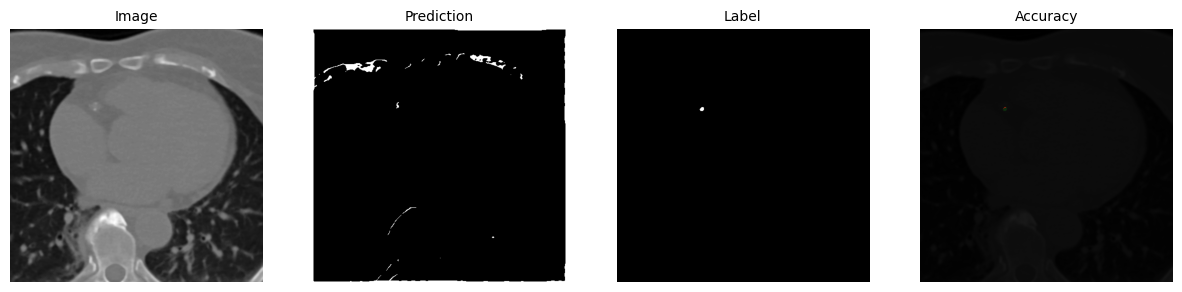

In [201]:
run_inference(333, 98)

Image Number: 559


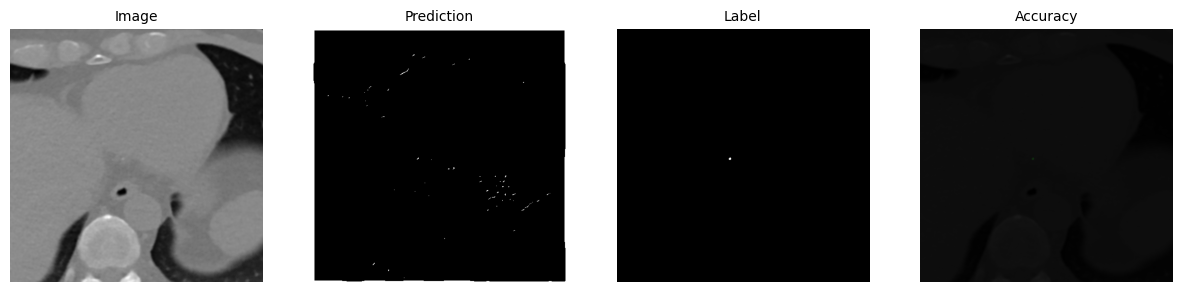

Image Number: 559


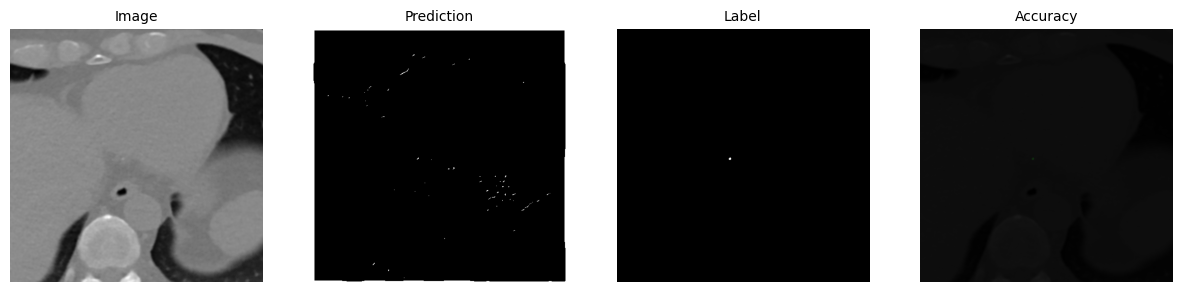

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 460


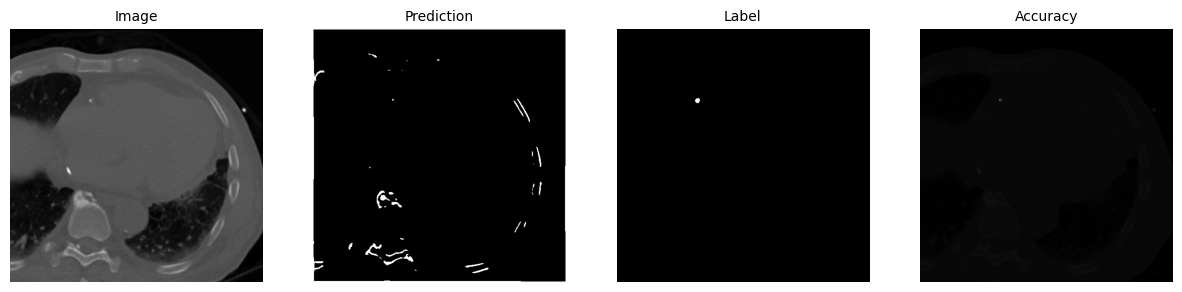

Image Number: 349


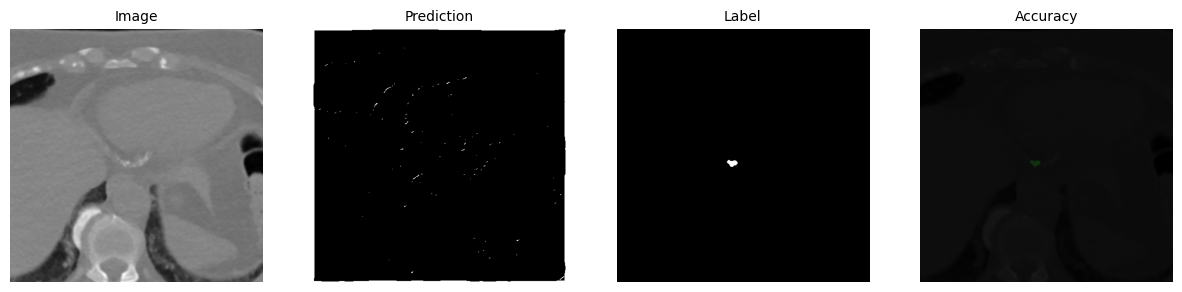

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 345


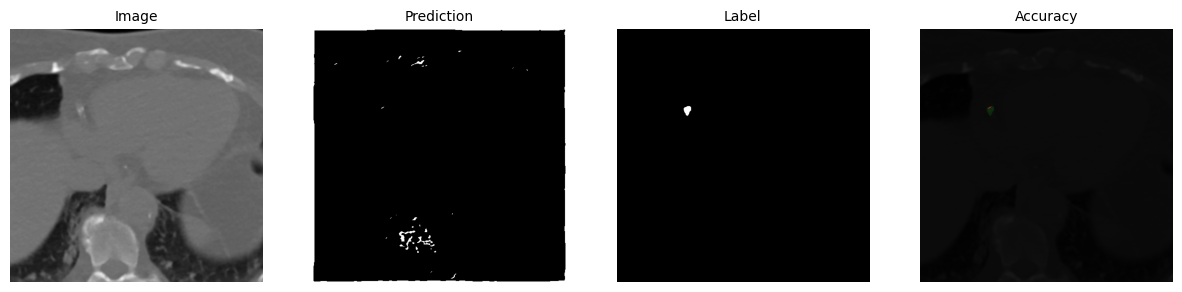

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 471


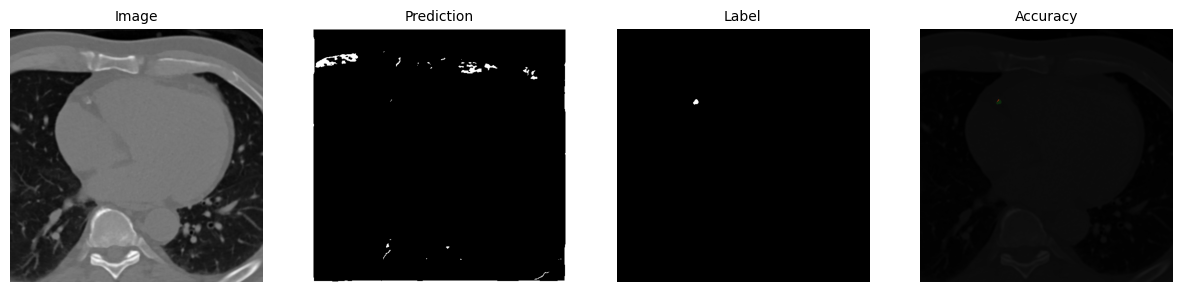

Image Number: 550


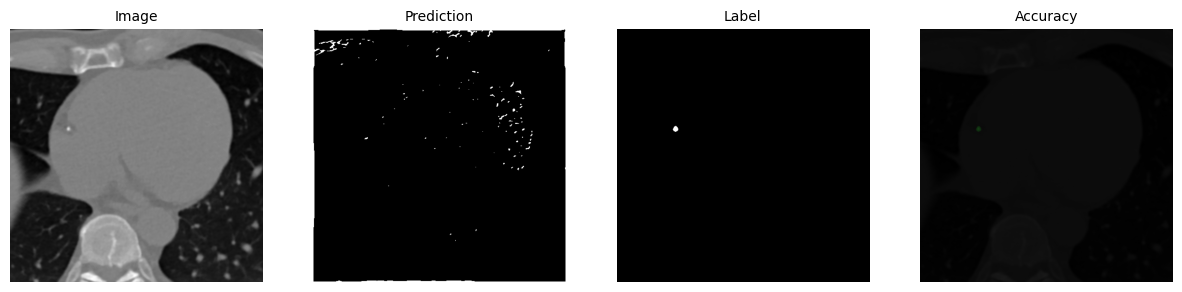

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 566


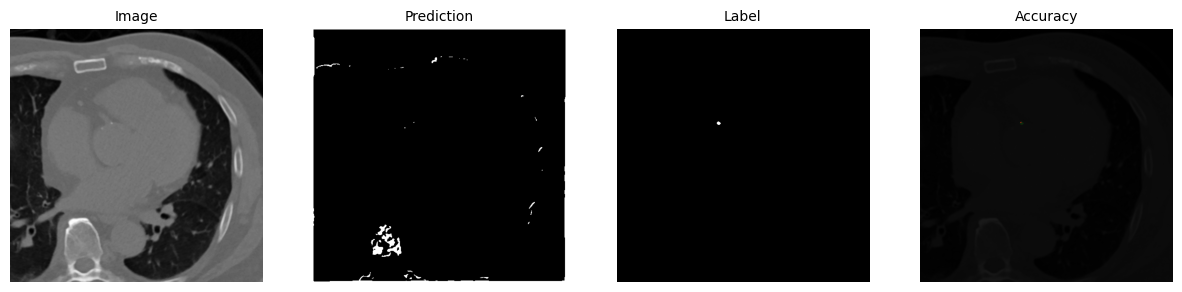

Image Number: 465


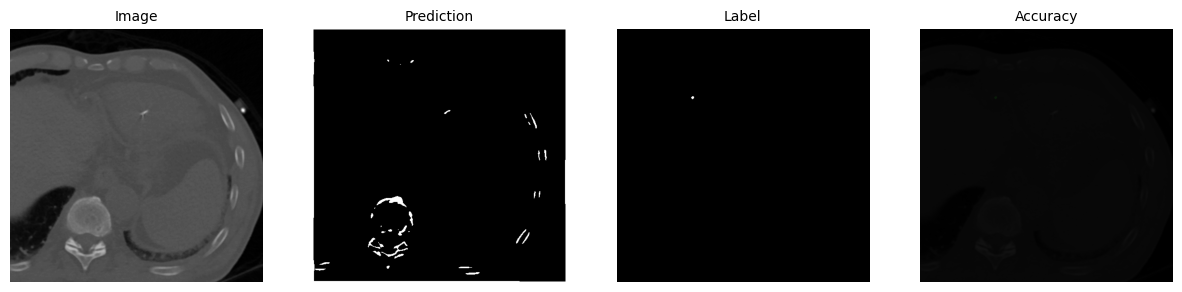

Image Number: 374


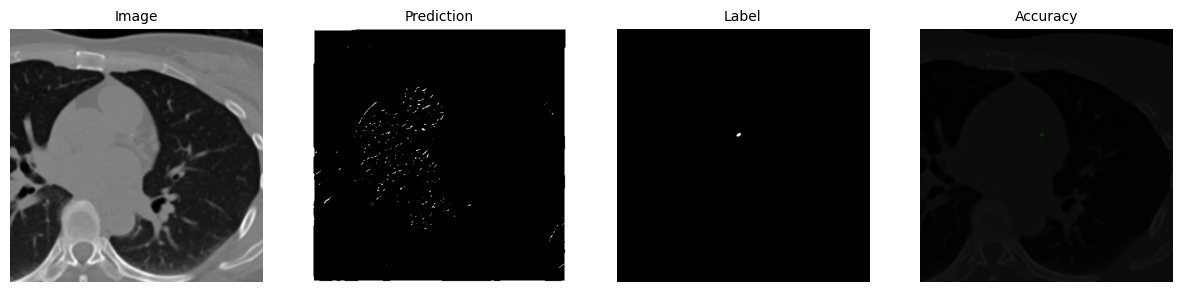

In [202]:
for i in range(10):
    infer_model()

# Test Loss

In [203]:
criterion_dice = diceCoef()

In [204]:
bce_loss = 0
iou_loss = 0
dice_loss = 0

with torch.no_grad():
    for x,y in testDL:
        x, y = x.to(CFG.device), y.to(CFG.device)
        pred = m(x)
        pred = pred*x
        loss_bce = criterion_bce(pred, y)
        loss_dice = criterion_dice(pred,y)
        loss_iou = criterion_iou(pred, y)
        bce_loss += loss_bce
        iou_loss += loss_iou
        dice_loss += loss_dice
BCE_LOSS = bce_loss/len(testDL)
DICE_LOSS = dice_loss/len(testDL)
IOU_LOSS = iou_loss/len(testDL)
print(f"BCE: {BCE_LOSS}")
print(f"DICE: {DICE_LOSS}")
print(f"IOU: {IOU_LOSS}")

BCE: 0.6933704018592834
DICE: 0.9913886785507202
IOU: 0.9914522767066956


Include my work in abstract

# Time

In [205]:
inf_images = []
for i in range(100):
    img = test[i][0]
    img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    inf_images.append(img)

In [206]:
%%time
for i in inf_images:
    m(i)

CPU times: total: 46.9 ms
Wall time: 1.67 s
